In [1]:
import pandas as pd, numpy as np
from pathlib import Path

# ──────────────────────────────────────────────────────────────────────────────
# Helper utilities (assumes you have these already, but they are repeated here
# so the cell is completely self-contained)
# ──────────────────────────────────────────────────────────────────────────────
def load_csv(path, sep=","):
    """Read CSV with a fallback encoding."""
    try:
        return pd.read_csv(path, sep=sep)
    except UnicodeDecodeError:
        return pd.read_csv(path, sep=sep, encoding="ISO-8859-1")

def coerce_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """Turn numeric-like object columns into float.""" 
    for col in df.columns:
        coerced = pd.to_numeric(
            df[col].astype(str).str.replace(r"[,\s]", "", regex=True),
            errors="coerce",
        )
        if coerced.notna().any():
            df[col] = coerced.astype(float)
    return df

def summarize(df: pd.DataFrame) -> pd.DataFrame:
    """Return n_unique / mean / median / std for numeric cols (2-decimals)."""
    num = df.select_dtypes(include="number")
    return pd.concat(
        {
            "n_unique": num.nunique(),
            "mean":     num.mean(),
            "median":   num.median(),
            "std":      num.std(),
        },
        axis=1,
    ).round(2)

# ──────────────────────────────────────────────────────────────────────────────
# File list  (path, delimiter)
# ──────────────────────────────────────────────────────────────────────────────
csv_paths = {
    "bank-full":            ("bank+marketing/bank/bank-full.csv",               ";"),
    "bank":                 ("bank+marketing/bank/bank.csv",                    ";"),
    "bank-additional-full": ("bank+marketing/bank-additional/bank-additional-full.csv", ";"),
    "bank-additional":      ("bank+marketing/bank-additional/bank-additional.csv",     ";"),
    "TCGA_Mutations_all":   ("glioma+grading+clinical+and+mutation+features+dataset/TCGA_GBM_LGG_Mutations_all.csv", ","),
    "TCGA_InfoWithGrade":   ("glioma+grading+clinical+and+mutation+features+dataset/TCGA_InfoWithGrade.csv",         ","),
    "winequality-red":      ("wine+quality/winequality-red.csv",   ";"),
    "winequality-white":    ("wine+quality/winequality-white.csv", ";"),
    "diabetes":             ("diabetes.csv", ","),
    "spotify":              ("Most Streamed Spotify Songs 2024.csv", ","),
}

out_dir = Path("numeric_summaries")
out_dir.mkdir(exist_ok=True)

# ──────────────────────────────────────────────────────────────────────────────
# 1-5 ▸ load → numeric-only → drop-NaNs (cols then rows) → summarise → save
# ──────────────────────────────────────────────────────────────────────────────
for name, (path_str, sep) in csv_paths.items():
    path = Path(path_str)
    print(f"\n🔹 {name} — delimiter '{sep}'")
    if not path.exists():
        print("   ⚠️  File not found, skipping.")
        continue

    # 1 ▸ read + coerce numeric-looking strings
    df = coerce_numeric(load_csv(path, sep=sep))

    # 2 ▸ keep only numeric columns
    df = df.select_dtypes(include="number")

    # 3 ▸ drop columns with any NaNs, then rows with any NaNs
    df = df.dropna(axis=1, how="any").dropna(axis=0, how="any")

    if df.empty:
        print("   ℹ️  Nothing left after cleaning; skipping.")
        continue

    # 4 ▸ calculate summary statistics
    summary = summarize(df)

    # 5 ▸ save + quick report
    print(f"   Rows (after cleaning): {len(df):,}")
    print(f"   Numeric features     : {len(summary)}")
    display(summary.head())           # comment out if not in Jupyter

    outfile = out_dir / f"{name}_summary.csv"
    summary.to_csv(outfile)
    print(f"   ✅  saved → {outfile}")

print("\n🎉  Done. All summaries are in numeric_summaries/")



🔹 bank-full — delimiter ';'
   Rows (after cleaning): 45,211
   Numeric features     : 7


,n_unique,mean,median,std
age,77,40.94,39.0,10.62
balance,7168,1362.27,448.0,3044.77
day,31,15.81,16.0,8.32
duration,1573,258.16,180.0,257.53
campaign,48,2.76,2.0,3.10


   ✅  saved → numeric_summaries/bank-full_summary.csv

🔹 bank — delimiter ';'
   Rows (after cleaning): 4,521
   Numeric features     : 7


,n_unique,mean,median,std
age,67,41.17,39.0,10.58
balance,2353,1422.66,444.0,3009.64
day,31,15.92,16.0,8.25
duration,875,263.96,185.0,259.86
campaign,32,2.79,2.0,3.11


   ✅  saved → numeric_summaries/bank_summary.csv

🔹 bank-additional-full — delimiter ';'
   Rows (after cleaning): 41,188
   Numeric features     : 10


,n_unique,mean,median,std
age,78,40.02,38.0,10.42
duration,1544,258.29,180.0,259.28
campaign,42,2.57,2.0,2.77
pdays,27,962.48,999.0,186.91
previous,8,0.17,0.0,0.49


   ✅  saved → numeric_summaries/bank-additional-full_summary.csv

🔹 bank-additional — delimiter ';'
   Rows (after cleaning): 4,119
   Numeric features     : 10


,n_unique,mean,median,std
age,67,40.11,38.0,10.31
duration,828,256.79,181.0,254.70
campaign,25,2.54,2.0,2.57
pdays,21,960.42,999.0,191.92
previous,7,0.19,0.0,0.54


   ✅  saved → numeric_summaries/bank-additional_summary.csv

🔹 TCGA_Mutations_all — delimiter ','
   ℹ️  Nothing left after cleaning; skipping.

🔹 TCGA_InfoWithGrade — delimiter ','
   Rows (after cleaning): 839
   Numeric features     : 24


,n_unique,mean,median,std
Grade,2,0.42,0.00,0.49
Gender,2,0.42,0.00,0.49
Age_at_diagnosis,766,50.94,51.55,15.70
Race,4,0.11,0.00,0.37
IDH1,2,0.48,0.00,0.50


   ✅  saved → numeric_summaries/TCGA_InfoWithGrade_summary.csv

🔹 winequality-red — delimiter ';'
   Rows (after cleaning): 1,599
   Numeric features     : 12


,n_unique,mean,median,std
fixed acidity,96,8.32,7.90,1.74
volatile acidity,143,0.53,0.52,0.18
citric acid,80,0.27,0.26,0.19
residual sugar,91,2.54,2.20,1.41
chlorides,153,0.09,0.08,0.05


   ✅  saved → numeric_summaries/winequality-red_summary.csv

🔹 winequality-white — delimiter ';'
   Rows (after cleaning): 4,898
   Numeric features     : 12


,n_unique,mean,median,std
fixed acidity,68,6.85,6.80,0.84
volatile acidity,125,0.28,0.26,0.10
citric acid,87,0.33,0.32,0.12
residual sugar,310,6.39,5.20,5.07
chlorides,160,0.05,0.04,0.02


   ✅  saved → numeric_summaries/winequality-white_summary.csv

🔹 diabetes — delimiter ','
   Rows (after cleaning): 768
   Numeric features     : 9


,n_unique,mean,median,std
Pregnancies,17,3.85,3.0,3.37
Glucose,136,120.89,117.0,31.97
BloodPressure,47,69.11,72.0,19.36
SkinThickness,51,20.54,23.0,15.95
Insulin,186,79.80,30.5,115.24


   ✅  saved → numeric_summaries/diabetes_summary.csv

🔹 spotify — delimiter ','
   Rows (after cleaning): 4,600
   Numeric features     : 3


,n_unique,mean,median,std
All Time Rank,4577,2290.68,2290.5,1322.88
Track Score,862,41.84,29.9,38.54
Explicit Track,2,0.36,0.0,0.48


   ✅  saved → numeric_summaries/spotify_summary.csv

🎉  Done. All summaries are in numeric_summaries/


In [2]:
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# 0 ▸ Imports
# ──────────────────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, warnings, json
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing  import StandardScaler
from sklearn.pipeline       import Pipeline
from sklearn.linear_model   import Lasso, LogisticRegression
from sklearn.metrics        import r2_score, roc_auc_score, accuracy_score

warnings.filterwarnings("ignore")

# ──────────────────────────────────────────────────────────────────────────────
# 1 ▸ Helper functions  (load_csv ◂─► coerce_numeric ◂─► clean_features)
# ──────────────────────────────────────────────────────────────────────────────
def load_csv(path, sep=","):
    """Read CSV with UTF-8 fallback → ISO-8859-1."""
    try:
        return pd.read_csv(path, sep=sep)
    except UnicodeDecodeError:
        return pd.read_csv(path, sep=sep, encoding="ISO-8859-1")

def coerce_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """Turn numeric-like object columns into float dtype."""
    for col in df.columns:
        coerced = pd.to_numeric(
            df[col].astype(str).str.replace(r"[,\s]", "", regex=True),
            errors="coerce",
        )
        if coerced.notna().any():          # at least one real number
            df[col] = coerced.astype(float)
    return df

def clean_features(df: pd.DataFrame) -> pd.DataFrame:
    """Numeric-only → drop NaN columns → drop NaN rows."""
    df = coerce_numeric(df)
    df = df.select_dtypes(include="number")       # keep numeric cols only
    df = df.dropna(axis=1, how="any")             # drop cols w/ NaN
    df = df.dropna(axis=0, how="any")             # drop rows w/ NaN
    return df

# ──────────────────────────────────────────────────────────────────────────────
# 2 ▸ Dataset list & target-column mapping
# ──────────────────────────────────────────────────────────────────────────────
csv_paths = {
    "bank-full":            ("bank+marketing/bank/bank-full.csv",               ";"),
    "bank":                 ("bank+marketing/bank/bank.csv",                    ";"),
    "bank-additional-full": ("bank+marketing/bank-additional/bank-additional-full.csv", ";"),
    "bank-additional":      ("bank+marketing/bank-additional/bank-additional.csv",     ";"),
    "TCGA_InfoWithGrade":   ("glioma+grading+clinical+and+mutation+features+dataset/TCGA_InfoWithGrade.csv", ","),
    "winequality-red":      ("wine+quality/winequality-red.csv",   ";"),
    "winequality-white":    ("wine+quality/winequality-white.csv", ";"),
    "diabetes":             ("diabetes.csv", ","),
    "spotify":              ("Most Streamed Spotify Songs 2024.csv", ","),
}

y_cols = {
    # classification
    "bank-full":            "y",
    "bank":                 "y",
    "bank-additional-full": "y",
    "bank-additional":      "y",
    "diabetes":             "Outcome",
    "TCGA_InfoWithGrade":   "Grade",
    # regression
    "winequality-red":      "quality",
    "winequality-white":    "quality",
    "spotify":              "Spotify Streams",       # <── updated column name
}

class_tasks = {
    "bank-full", "bank", "bank-additional-full", "bank-additional",
    "diabetes", "TCGA_InfoWithGrade",
}

# ──────────────────────────────────────────────────────────────────────────────
# 3 ▸ Hyper-parameter grids
# ──────────────────────────────────────────────────────────────────────────────
lasso_grid  = {"model__alpha": 10.0**np.linspace(-4, 1, 10)}
logreg_grid = {"model__C":     10.0**np.linspace(-3, 3, 13)}

# ──────────────────────────────────────────────────────────────────────────────
# 4 ▸ Main loop
# ──────────────────────────────────────────────────────────────────────────────
results = []

for name, (csv_path, sep) in csv_paths.items():
    path = Path(csv_path)
    print(f"\n🔹 {name}")
    if not path.exists():
        print("   ⚠️  File not found, skipping.")
        continue

    # -- load
    print(f"   → DEBUG: using sep='{sep}'  for {path.name}")
    raw = load_csv(path, sep=sep)
    if name not in y_cols or y_cols[name] not in raw.columns:
        print("   ❌  Target column missing; skipping.")
        continue

    y_raw = raw[y_cols[name]]
    y_raw = pd.to_numeric(
    y_raw.astype(str).str.replace(r"[,\s]", "", regex=True),
    errors="coerce"
)
    X_raw = raw.drop(columns=[y_cols[name]])

    # -- preprocess X
    #X = clean_features(X_raw)
    X = clean_features(X_raw).reset_index(drop=True)
    y = y_raw.reset_index(drop=True)  
    print(f"   after clean_features ➜ shape {X.shape}")
    print(f"   numeric cols: {list(X.columns)[:6]} ...")
    if y.isna().any():
        mask = y.notna()
        X, y = X.loc[mask], y[mask]

    if X.empty or y.empty:
        print("   ℹ️  No usable numeric features; skipping.")
        continue

    task = "classification" if name in class_tasks else "regression"

    # -- split 50-50 (stratify if classification)
    strat = y if task == "classification" else None
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.5, random_state=42, stratify=strat
    )

    # -- pipeline & CV
    if task == "regression":
        pipe = Pipeline(
            [("scaler", StandardScaler()), ("model", Lasso(max_iter=10000))]
        )
        grid = lasso_grid
        cv   = 10
        scorer = "r2"
    else:
        y_tr = pd.Categorical(y_tr).codes
        y_te = pd.Categorical(y_te).codes
        pipe = Pipeline(
            [("scaler", StandardScaler()),
             ("model",  LogisticRegression(penalty="l1",
                                           solver="liblinear",
                                           max_iter=2000))]
        )
        grid = logreg_grid
        cv   = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
        scorer = "roc_auc"

    gscv = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring=scorer)
    gscv.fit(X_tr, y_tr)
    best = gscv.best_estimator_
    best_param = list(gscv.best_params_.values())[0]
    print("   Best hyper-parameter:", best_param)

    # -- evaluate
    if task == "regression":
        y_pred = best.predict(X_te)
        r2  = r2_score(y_te, y_pred)
        err = 1 - r2
        print(f"   R² = {r2:.3f}  ⇒  test-error (1-R²) = {err:.3f}")
        results.append({"dataset": name, "task": "reg", "alpha": best_param,
                        "R2": r2, "1-R2": err})
    else:
        prob = best.predict_proba(X_te)[:, 1]
        auc  = roc_auc_score(y_te, prob)
        acc  = accuracy_score(y_te, best.predict(X_te))
        err  = 1 - acc
        print(f"   AUROC = {auc:.3f},  Accuracy = {acc:.3f},  Error = {err:.3f}")
        results.append({"dataset": name, "task": "cls", "C": best_param,
                        "AUROC": auc, "Accuracy": acc, "Error": err})

# ──────────────────────────────────────────────────────────────────────────────
# 5 ▸ Save consolidated results
# ──────────────────────────────────────────────────────────────────────────────
pd.DataFrame(results).to_csv("lasso_results.csv", index=False)
print("\n🎉  Done — per-dataset results in lasso_results.csv")



🔹 bank-full
   → DEBUG: using sep=';'  for bank-full.csv
   after clean_features ➜ shape (45211, 7)
   numeric cols: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays'] ...
   ℹ️  No usable numeric features; skipping.

🔹 bank
   → DEBUG: using sep=';'  for bank.csv
   after clean_features ➜ shape (4521, 7)
   numeric cols: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays'] ...
   ℹ️  No usable numeric features; skipping.

🔹 bank-additional-full
   → DEBUG: using sep=';'  for bank-additional-full.csv
   after clean_features ➜ shape (41188, 10)
   numeric cols: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate'] ...
   ℹ️  No usable numeric features; skipping.

🔹 bank-additional
   → DEBUG: using sep=';'  for bank-additional.csv
   after clean_features ➜ shape (4119, 10)
   numeric cols: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate'] ...
   ℹ️  No usable numeric features; skipping.

🔹 TCGA_InfoWithGrade
   → DEBUG: using sep=','  for

In [3]:
path = Path("bank+marketing/bank/bank.csv")     # or any of the variants
raw_semicolon = pd.read_csv(path, sep=";", nrows=3, header=None)
raw_comma     = pd.read_csv(path, sep=",", nrows=3, header=None)

print("semicolon read → shape", raw_semicolon.shape)
print(raw_semicolon.iloc[0, 0][:120], "...")    # show first 120 chars

print("\ncomma read     → shape", raw_comma.shape)
print(raw_comma.head(3))


semicolon read → shape (3, 17)
age ...

comma read     → shape (3, 1)
                                                   0
0  age;"job";"marital";"education";"default";"bal...
1  30;"unemployed";"married";"primary";"no";1787;...
2  33;"services";"married";"secondary";"no";4789;...


In [4]:
path = "bank+marketing/bank/bank.csv"   # pick any bank*.csv you like
df   = load_csv(path, sep=";")          # same load_csv you already defined
df   = coerce_numeric(df)               # turn numerics into float

num = df.select_dtypes("number")        # keep numeric columns only

print("Numeric columns:", num.shape[1])
print(num.head())                       # quick peek

# Count NaNs per numeric column
na_counts = num.isna().sum()
print("\nColumns that *do* have NaNs:")
print(na_counts[na_counts > 0])


Numeric columns: 7
    age  balance   day  duration  campaign  pdays  previous
0  30.0   1787.0  19.0      79.0       1.0   -1.0       0.0
1  33.0   4789.0  11.0     220.0       1.0  339.0       4.0
2  35.0   1350.0  16.0     185.0       1.0  330.0       1.0
3  30.0   1476.0   3.0     199.0       4.0   -1.0       0.0
4  59.0      0.0   5.0     226.0       1.0   -1.0       0.0

Columns that *do* have NaNs:
Series([], dtype: int64)


In [7]:
# ──────────────────────────────────────────────────────────────────────────────
# 0 ▸ Imports
# ──────────────────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, warnings, json
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing  import StandardScaler
from sklearn.pipeline       import Pipeline
from sklearn.linear_model   import Lasso, LogisticRegression
from sklearn.metrics        import r2_score, roc_auc_score, accuracy_score
warnings.filterwarnings("ignore")

# ──────────────────────────────────────────────────────────────────────────────
# 1 ▸ Helpers  (load_csv → coerce_numeric → clean_features)
# ──────────────────────────────────────────────────────────────────────────────
def load_csv(path, sep=","):
    try:
        return pd.read_csv(path, sep=sep)
    except UnicodeDecodeError:
        return pd.read_csv(path, sep=sep, encoding="ISO-8859-1")

def coerce_numeric(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        coerced = pd.to_numeric(
            df[col].astype(str).str.replace(r"[,\s]", "", regex=True),
            errors="coerce",
        )
        if coerced.notna().any():
            df[col] = coerced.astype(float)
    return df

def clean_features(df: pd.DataFrame) -> pd.DataFrame:
    df = coerce_numeric(df)
    df = df.select_dtypes("number").dropna(axis=1, how="any").dropna(axis=0, how="any")
    return df

# ──────────────────────────────────────────────────────────────────────────────
# 2 ▸ Dataset paths + y-column mapping
# ──────────────────────────────────────────────────────────────────────────────
csv_paths = {
    "bank-full":            ("bank+marketing/bank/bank-full.csv",               ";"),
    "bank":                 ("bank+marketing/bank/bank.csv",                    ";"),
    "bank-additional-full": ("bank+marketing/bank-additional/bank-additional-full.csv", ";"),
    "bank-additional":      ("bank+marketing/bank-additional/bank-additional.csv",     ";"),
    "TCGA_InfoWithGrade":   ("glioma+grading+clinical+and+mutation+features+dataset/TCGA_InfoWithGrade.csv", ","),
    "winequality-red":      ("wine+quality/winequality-red.csv",   ";"),
    "winequality-white":    ("wine+quality/winequality-white.csv", ";"),
    "diabetes":             ("diabetes.csv", ","),
    "spotify":              ("Most Streamed Spotify Songs 2024.csv", ","),
}

y_cols = {
    "bank-full":            "y",
    "bank":                 "y",
    "bank-additional-full": "y",
    "bank-additional":      "y",
    "diabetes":             "Outcome",
    "TCGA_InfoWithGrade":   "Grade",
    "winequality-red":      "quality",
    "winequality-white":    "quality",
    "spotify":              "Spotify Streams",
}

class_tasks = {
    "bank-full", "bank", "bank-additional-full", "bank-additional",
    "diabetes", "TCGA_InfoWithGrade",
}

# ──────────────────────────────────────────────────────────────────────────────
# 3 ▸ Hyper-parameter grids
# ──────────────────────────────────────────────────────────────────────────────
lasso_grid  = {"model__alpha": 10.0**np.linspace(-4, 1, 10)}
logreg_grid = {"model__C":     10.0**np.linspace(-3, 3, 13)}

# ──────────────────────────────────────────────────────────────────────────────
# 4 ▸ Main loop
# ──────────────────────────────────────────────────────────────────────────────
results = []

for name, (csv_path, sep) in csv_paths.items():
    path = Path(csv_path)
    print(f"\n🔹 {name}")
    if not path.exists():
        print("   ⚠️  File not found, skipping."); continue

    print(f"   → DEBUG: using sep='{sep}' for {path.name}")
    raw = load_csv(path, sep=sep)

    if name not in y_cols or y_cols[name] not in raw.columns:
        print("   ❌  Target column missing; skipping."); continue

    # ── identify task BEFORE coercing y ───────────────────────────────
    task = "classification" if name in class_tasks else "regression"

    # slice y and X
    y_raw = raw[y_cols[name]].reset_index(drop=True)
    X_raw = raw.drop(columns=[y_cols[name]])

    # only convert y to float for regression datasets
    if task == "regression":
        y_raw = pd.to_numeric(
            y_raw.astype(str).str.replace(r"[,\s]", "", regex=True),
            errors="coerce"
        )

    # preprocess X
    X = clean_features(X_raw).reset_index(drop=True)

    # drop rows where y is NaN (only affects regression)
    mask = y_raw.notna()
    X, y = X.loc[mask], y_raw.loc[mask].reset_index(drop=True)

    print(f"   after clean_features ➜ shape {X.shape}")
    print(f"   numeric cols: {list(X.columns)[:6]} ...")

    if X.empty or y.empty:
        print("   ℹ️  No usable data; skipping."); continue

    # ── split 50-50 (stratify for classification) ─────────────────────
    strat = y if task == "classification" else None
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.5, random_state=42, stratify=strat
    )

    # ── pipeline + CV ────────────────────────────────────────────────
    if task == "regression":
        pipe  = Pipeline([("scaler", StandardScaler()), ("model", Lasso(max_iter=10000))])
        grid  = lasso_grid
        cv    = 10
        score = "r2"
    else:
        y_tr = pd.Categorical(y_tr).codes
        y_te = pd.Categorical(y_te).codes
        pipe  = Pipeline([("scaler", StandardScaler()),
                          ("model",  LogisticRegression(penalty="l1",
                                                        solver="liblinear",
                                                        max_iter=2000))])
        grid  = logreg_grid
        cv    = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
        score = "roc_auc"

    gscv = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring=score)
    gscv.fit(X_tr, y_tr)
    best_param = list(gscv.best_params_.values())[0]
    print("   Best hyper-parameter:", best_param)

    # ── evaluation ───────────────────────────────────────────────────
    if task == "regression":
        r2   = r2_score(y_te, gscv.predict(X_te))
        err  = 1 - r2
        print(f"   R² = {r2:.3f}  ⇒  test-error (1-R²) = {err:.3f}")
        results.append({"dataset": name, "task": "reg", "alpha": best_param,
                        "R2": r2, "1-R2": err})
    else:
        prob = gscv.predict_proba(X_te)[:, 1]
        auc  = roc_auc_score(y_te, prob)
        acc  = accuracy_score(y_te, gscv.predict(X_te))
        err  = 1 - acc
        print(f"   AUROC = {auc:.3f}, Accuracy = {acc:.3f}, Error = {err:.3f}")
        results.append({"dataset": name, "task": "cls", "C": best_param,
                        "AUROC": auc, "Accuracy": acc, "Error": err})

# ──────────────────────────────────────────────────────────────────────────────
# 5 ▸ Save consolidated results
# ──────────────────────────────────────────────────────────────────────────────
pd.DataFrame(results).to_csv("lasso_results.csv", index=False)
print("\n🎉  Done — per-dataset results in lasso_results.csv")



🔹 bank-full
   → DEBUG: using sep=';' for bank-full.csv
   after clean_features ➜ shape (45211, 7)
   numeric cols: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays'] ...
   Best hyper-parameter: 0.03162277660168379
   AUROC = 0.836, Accuracy = 0.889, Error = 0.111

🔹 bank
   → DEBUG: using sep=';' for bank.csv
   after clean_features ➜ shape (4521, 7)
   numeric cols: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays'] ...
   Best hyper-parameter: 0.1
   AUROC = 0.824, Accuracy = 0.887, Error = 0.113

🔹 bank-additional-full
   → DEBUG: using sep=';' for bank-additional-full.csv
   after clean_features ➜ shape (41188, 10)
   numeric cols: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate'] ...
   Best hyper-parameter: 31.622776601683793
   AUROC = 0.924, Accuracy = 0.908, Error = 0.092

🔹 bank-additional
   → DEBUG: using sep=';' for bank-additional.csv
   after clean_features ➜ shape (4119, 10)
   numeric cols: ['age', 'duration', 'campaign', 'pdays', 

In [4]:
# ──────────────────────────────────────────────────────────────────────────────
# 0 ▸ imports
# ──────────────────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, warnings, json
from pathlib import Path

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, KFold, cross_val_score
)
from sklearn.preprocessing  import StandardScaler
from sklearn.pipeline       import make_pipeline
from sklearn.linear_model   import Lasso, LogisticRegression
from sklearn.metrics        import roc_auc_score, accuracy_score, r2_score

warnings.filterwarnings("ignore")

# ---------- helpers ----------------------------------------------------------
def load_csv(path, sep=","):
    try:
        return pd.read_csv(path, sep=sep)
    except UnicodeDecodeError:
        return pd.read_csv(path, sep=sep, encoding="ISO-8859-1")

def coerce_numeric(df):
    for c in df.columns:
        num = pd.to_numeric(df[c].astype(str).str.replace(r"[,\s]", "", regex=True),
                            errors="coerce")
        if num.notna().any():
            df[c] = num.astype(float)
    return df

def clean_features(df):
    df = coerce_numeric(df)
    return (
        df.select_dtypes("number")
          .dropna(axis=1, how="any")
          .dropna(axis=0, how="any")
    )

# ---------- dataset spec -----------------------------------------------------
csv_paths = {
    "bank":                 ("bank+marketing/bank/bank.csv",                    ";"),
    "diabetes":             ("diabetes.csv", ","),
    "TCGA_InfoWithGrade":   ("glioma+grading+clinical+and+mutation+features+dataset/TCGA_InfoWithGrade.csv", ","),
    "winequality-red":      ("wine+quality/winequality-red.csv",   ";"),
    "winequality-white":    ("wine+quality/winequality-white.csv", ";"),
    "spotify":              ("Most Streamed Spotify Songs 2024.csv", ","),
}

y_cols = {
    "bank":               "y",
    "diabetes":           "Outcome",
    "TCGA_InfoWithGrade": "Grade",
    "winequality-red":    "quality",
    "winequality-white":  "quality",
    "spotify":            "Spotify Streams",
}

class_tasks = {"bank", "diabetes", "TCGA_InfoWithGrade"}

# ---------- grids & CV objects ----------------------------------------------
alpha_grid = 10 ** np.linspace(-4, 1, 40)              # 40 alphas for Lasso
C_grid     = 10 ** np.linspace(-3, 3, 40)              # 40 Cs   for LogReg
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
kf  = KFold(n_splits=10, shuffle=True, random_state=0)

# ---------- main loop --------------------------------------------------------
all_results = {}

for name, (csv_path, sep) in csv_paths.items():
    print(f"\n🔹 {name}")
    raw = load_csv(Path(csv_path), sep=sep)
    X_raw, y_raw = raw.drop(columns=[y_cols[name]]), raw[y_cols[name]]
    
    task = "classification" if name in class_tasks else "regression"

    # make y numeric only for regression
    if task == "regression":
        y_raw = pd.to_numeric(y_raw.astype(str).str.replace(r"[,\s]", "", regex=True),
                              errors="coerce")
    
    # preprocess X
    X = clean_features(X_raw).reset_index(drop=True)
    y = y_raw.reset_index(drop=True)
    mask = y.notna()
    X, y = X.loc[mask], y[mask]

    if X.empty:
        print("   ⚠️  No usable rows/columns – skipping."); continue
    
    # 50–50 outer split
    strat = y if task == "classification" else None
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.5, random_state=42, stratify=strat
    )

    per_k = {}   # k -> (best_score, best_model)

    # sweep grid
    if task == "regression":
        for alpha in alpha_grid:
            mdl = make_pipeline(StandardScaler(),
                                Lasso(alpha=alpha, max_iter=10000))
            cv_score = cross_val_score(
                mdl, X_tr, y_tr, cv=kf, scoring="r2", n_jobs=-1
            ).mean()
            mdl.fit(X_tr, y_tr)
            k = int((mdl[-1].coef_ != 0).sum())
            if k == 0: continue
            if (k not in per_k) or (cv_score > per_k[k][0]):
                per_k[k] = (cv_score, mdl)
    else:
        for C in C_grid:
            mdl = make_pipeline(StandardScaler(),
                                LogisticRegression(
                                    penalty="l1", solver="liblinear",
                                    C=C, max_iter=2000
                                ))
            cv_score = cross_val_score(
                mdl, X_tr, y_tr, cv=skf, scoring="roc_auc", n_jobs=-1
            ).mean()
            mdl.fit(X_tr, y_tr)
            k = int((mdl[-1].coef_ != 0).sum())
            if k == 0: continue
            if (k not in per_k) or (cv_score > per_k[k][0]):
                per_k[k] = (cv_score, mdl)

    # evaluate the “best model at each k” on the outer test set
    rows = []
    for k, (cv_sc, mdl) in sorted(per_k.items()):
        if task == "regression":
            r2  = r2_score(y_te, mdl.predict(X_te))
            rows.append({"k": k, "cv_R2": cv_sc, "test_R2": r2,
                         "test_1-R2": 1 - r2})
        else:
            prob = mdl.predict_proba(X_te)[:, 1]
            auc  = roc_auc_score(y_te, prob)
            acc  = accuracy_score(y_te, mdl.predict(X_te))
            rows.append({"k": k, "cv_AUROC": cv_sc,
                         "test_AUROC": auc, "test_acc": acc})

    result_df = pd.DataFrame(rows)
    all_results[name] = result_df
    result_df.to_csv(f"{name}_results.csv", index=False)
    display(result_df.head())

# the dict all_results now holds one DataFrame per dataset



🔹 bank


,k,cv_AUROC,test_AUROC,test_acc
0,1,0.817029,0.813729,0.884564
1,2,0.827279,0.822379,0.885007
2,3,0.837356,0.823318,0.885007
3,4,0.838144,0.822629,0.887218
4,5,0.839750,0.822995,0.887660



🔹 diabetes


,k,cv_AUROC,test_AUROC,test_acc
0,1,0.780978,0.793224,0.705729
1,2,0.779396,0.802791,0.729167
2,3,0.795802,0.814478,0.760417
3,4,0.816484,0.828179,0.747396
4,5,0.816484,0.829940,0.757812



🔹 TCGA_InfoWithGrade


,k,cv_AUROC,test_AUROC,test_acc
0,1,0.843832,0.873230,0.861905
1,2,0.887443,0.915099,0.861905
2,4,0.895449,0.916880,0.880952
3,7,0.899385,0.918359,0.883333
4,11,0.900822,0.923761,0.888095



🔹 winequality-red


,k,cv_R2,test_R2,test_1-R2
0,1,0.118542,0.108996,0.891004
1,2,0.291389,0.264985,0.735015
2,3,0.306749,0.279471,0.720529
3,4,0.320828,0.296250,0.703750
4,5,0.342388,0.324217,0.675783



🔹 winequality-white


,k,cv_R2,test_R2,test_1-R2
0,1,0.131588,0.130302,0.869698
1,2,0.201289,0.197959,0.802041
2,3,0.218341,0.213795,0.786205
3,5,0.235313,0.228107,0.771893
4,6,0.250117,0.239163,0.760837



🔹 spotify


,k,cv_R2,test_R2,test_1-R2
0,3,0.088861,0.096024,0.903976


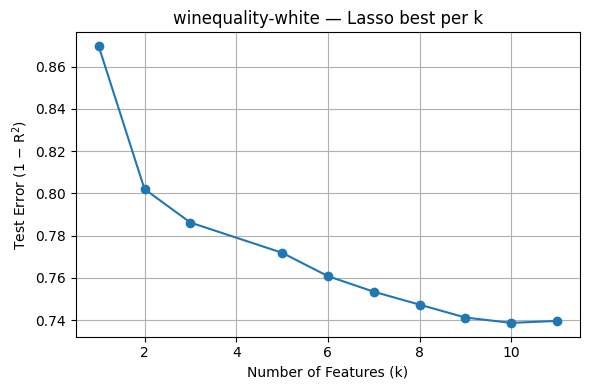

   ✅  saved → winequality-white_lasso_k.png
lasso: empty after cleaning — skip


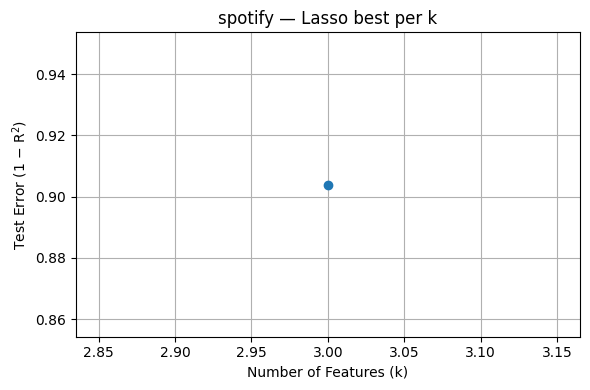

   ✅  saved → spotify_lasso_k.png


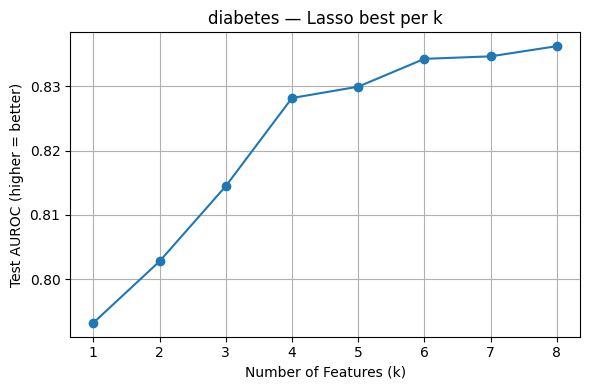

   ✅  saved → diabetes_lasso_k.png


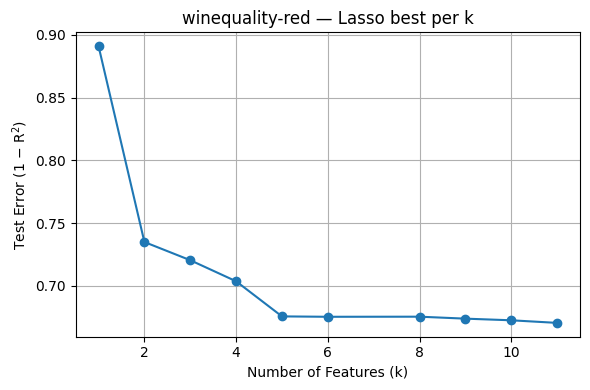

   ✅  saved → winequality-red_lasso_k.png


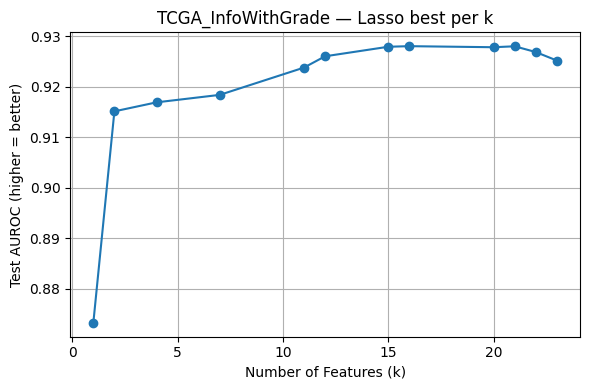

   ✅  saved → TCGA_InfoWithGrade_lasso_k.png


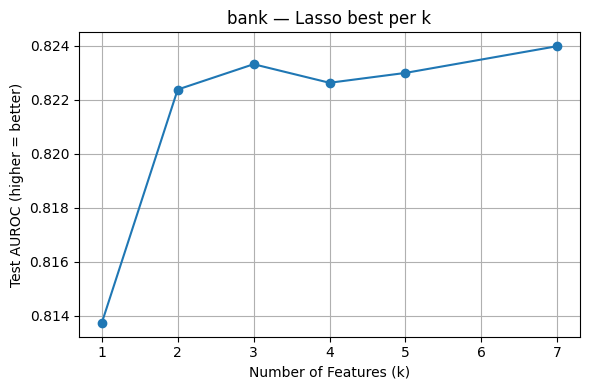

   ✅  saved → bank_lasso_k.png


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# ── helper: choose the y-axis series & label ───────────────────────
def pick_y(df: pd.DataFrame):
    """
    Return (Series, y-label) for the first recognised metric column.
    Priority: AUROC → 1-R² → accuracy.
    """
    if "test_AUROC" in df.columns:
        return df["test_AUROC"], "Test AUROC (higher = better)"
    for col in ["test_1-R2", "test_1_minus_R2", "test_1_R2"]:
        if col in df.columns:
            return df[col], "Test Error (1 − R$^2$)"
    for col in ["test_acc", "test_accuracy"]:
        if col in df.columns:
            return df[col], "Test Accuracy"
    raise KeyError("No recognised metric column.")

# ── load each “best-at-k” result file and plot ─────────────────────
for csv_file in Path().glob("*_results.csv"):
    name = csv_file.stem.replace("_results", "")
    
    df = (pd.read_csv(csv_file, index_col=0)   # first column was k
            .rename_axis("k")
            .reset_index())
    
    df.columns = df.columns.str.strip().str.replace("\ufeff", "", regex=False)
    df["k"] = pd.to_numeric(df["k"], errors="coerce")
    df = df.dropna(subset=["k"]).sort_values("k")
    if df.empty:
        print(f"{name}: empty after cleaning — skip"); continue
    
    try:
        y_series, y_label = pick_y(df)
    except KeyError as err:
        print(f"{name}: {err}"); continue
    
    plt.figure(figsize=(6, 4))
    plt.plot(df["k"], y_series, marker="o")
    plt.xlabel("Number of Features (k)")
    plt.ylabel(y_label)
    plt.title(f"{name} — Lasso best per k")
    plt.grid(True)
    plt.tight_layout()
    out_path = f"{name}_lasso_k.png"
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"   ✅  saved → {out_path}")

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Preferred test‑metric column names, in order of priority
metric_choices_cls = ["test_AUROC", "test_AUC", "test_accuracy", "test_acc"]
metric_choices_reg = ["test_1-R2", "test_R2", "test_MSE", "test_RMSE", "test_MAE"]

for csv_file in Path().glob("*_results.csv"):
    name = csv_file.stem.replace("_results", "")
    
    # ── read the CSV and guarantee a “k” column ───────────────────
    df = pd.read_csv(csv_file)                 # 1st try: plain read
    if "k" not in df.columns:                  # fallback: first col was index
        df = (
            pd.read_csv(csv_file, index_col=0) # treat col‑0 as index
              .rename_axis("k")                # give it a name
              .reset_index()                   # make it a column
        )
    if "k" not in df.columns:                  # still no “k” → skip
        print(f"⚠️  {name}: no 'k' column found; skipping.")
        continue

    # ── pick the first recognised metric column ──────────────────
    metric = next((c for c in metric_choices_cls if c in df.columns), None)
    task   = "cls" if metric else None
    if metric is None:                         # maybe it’s regression
        metric = next((c for c in metric_choices_reg if c in df.columns), None)
        task   = "reg" if metric else None
    if metric is None:                         # nothing we understand
        print(f"⚠️  {name}: no recognised test metric column; columns = {df.columns.tolist()}")
        continue

    # ── plot ──────────────────────────────────────────────────────
    plt.figure(figsize=(6, 4))
    plt.plot(df["k"], df[metric], marker="o")
    
    if task == "cls":
        plt.ylabel(metric.replace("test_", "Test ").replace("_", " ") + " (higher = better)")
    else:  # regression
        if metric == "test_1-R2":
            plt.ylabel("Test Error (1 − R$^2$)")
        else:
            plt.ylabel(metric.replace("test_", "Test ").replace("_", " "))
    
    plt.xlabel("Number of Features (k)")
    plt.title(f"{name} — Lasso best per k")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


⚠️  lasso: no recognised test metric column; columns = ['k', 'task', 'C', 'AUROC', 'Accuracy', 'Error', 'alpha', 'R2', '1-R2']


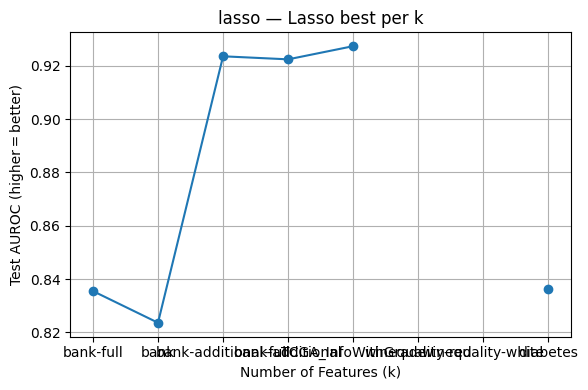

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# ── helper: pick task + metric column from the dataframe ───────────
def choose_metric(df):
    """Return (task, metric_col, series_to_plot, y_label)."""
    
    # If the author recorded the task explicitly, trust it
    task_col = df["task"].iloc[0].lower() if "task" in df.columns else None
    
    # ----- classification ---------------------------------------------------
    cls_cols = ["AUROC", "Accuracy", "Error"]
    if (task_col == "classification") or any(c in df.columns for c in cls_cols):
        if "AUROC" in df.columns:
            return ("cls", "AUROC", df["AUROC"], "Test AUROC (higher = better)")
        if "Accuracy" in df.columns:
            return ("cls", "Accuracy", df["Accuracy"], "Test Accuracy (higher = better)")
        if "Error" in df.columns:
            return ("cls", "Error", df["Error"], "Classification Error (lower = better)")
    
    # ----- regression -------------------------------------------------------
    reg_cols = ["1-R2", "R2", "MSE", "RMSE", "MAE", "Error"]
    if (task_col == "regression") or any(c in df.columns for c in reg_cols):
        if "1-R2" in df.columns:
            return ("reg", "1-R2", df["1-R2"], "Test Error (1 − R$^2$)")
        if "R2" in df.columns:
            return ("reg", "R2", 1 - df["R2"], "Test Error (1 − R$^2$)  [from R$^2$]")
        if "MSE" in df.columns:
            return ("reg", "MSE", df["MSE"], "Test MSE (lower = better)")
        if "RMSE" in df.columns:
            return ("reg", "RMSE", df["RMSE"], "Test RMSE (lower = better)")
        if "MAE" in df.columns:
            return ("reg", "MAE", df["MAE"], "Test MAE (lower = better)")
        if "Error" in df.columns:                 # generic label
            return ("reg", "Error", df["Error"], "Regression Error (lower = better)")
    
    # nothing recognised
    return (None, None, None, None)

# ── main loop over all *_results.csv files ─────────────────────────
for csv_file in Path().glob("*_results.csv"):
    name = csv_file.stem.replace("_results", "")
    
    # read CSV and make sure we have a proper “k” column
    df = pd.read_csv(csv_file)
    if "k" not in df.columns:
        df = (
            pd.read_csv(csv_file, index_col=0)
              .rename_axis("k")
              .reset_index()
        )
    if "k" not in df.columns:
        print(f"⚠️  {name}: no 'k' column found; skipping.")
        continue
    
    # choose which metric to plot
    task, metric_col, y_series, y_label = choose_metric(df)
    if metric_col is None:
        print(f"⚠️  {name}: no recognised metric column; columns = {df.columns.tolist()}")
        continue
    
    # ── plot ──────────────────────────────────────────────────────
    plt.figure(figsize=(6, 4))
    plt.plot(df["k"], y_series, marker="o")
    plt.xlabel("Number of Features (k)")
    plt.ylabel(y_label)
    plt.title(f"{name} — Lasso best per k")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from pandas.api.types import is_numeric_dtype

# ── helper: pick task + metric column from the dataframe ───────────
def choose_metric(df):
    """Return (task, metric_col, series_to_plot, y_label)."""
    
    # If the author recorded the task explicitly, trust it
    task_col = df["task"].iloc[0].lower() if "task" in df.columns else None
    
    # ----- classification ---------------------------------------------------
    cls_cols = ["AUROC", "Accuracy", "Error"]
    if (task_col == "classification") or any(c in df.columns for c in cls_cols):
        if "AUROC" in df.columns:
            return ("cls", "AUROC", df["AUROC"], "Test AUROC (higher = better)")
        if "Accuracy" in df.columns:
            return ("cls", "Accuracy", df["Accuracy"], "Test Accuracy (higher = better)")
        if "Error" in df.columns:
            return ("cls", "Error", df["Error"], "Classification Error (lower = better)")
    
    # ----- regression -------------------------------------------------------
    reg_cols = ["1-R2", "R2", "MSE", "RMSE", "MAE", "Error"]
    if (task_col == "regression") or any(c in df.columns for c in reg_cols):
        if "1-R2" in df.columns:
            return ("reg", "1-R2", df["1-R2"], "Test Error (1 − R$^2$)")
        if "R2" in df.columns:
            return ("reg", "R2", 1 - df["R2"], "Test Error (1 − R$^2$)  [from R$^2$]")
        if "MSE" in df.columns:
            return ("reg", "MSE", df["MSE"], "Test MSE (lower = better)")
        if "RMSE" in df.columns:
            return ("reg", "RMSE", df["RMSE"], "Test RMSE (lower = better)")
        if "MAE" in df.columns:
            return ("reg", "MAE", df["MAE"], "Test MAE (lower = better)")
        if "Error" in df.columns:                 # generic label
            return ("reg", "Error", df["Error"], "Regression Error (lower = better)")
    
    # nothing recognised
    return (None, None, None, None)


for csv_file in Path().glob("*_results.csv"):
    name = csv_file.stem.replace("_results", "")
    
    # --- read CSV -----------------------------------------------------------
    df = pd.read_csv(csv_file)
    if "k" not in df.columns:
        # first column is index → that’s the DATASET, not k
        df = (
            pd.read_csv(csv_file, index_col=0)
              .rename_axis("dataset")      # << renamed to avoid collision
              .reset_index()
        )

    # if two columns named “k” slipped in, keep the numeric one
    k_cols = [c for c in df.columns if c.startswith("k")]
    if len(k_cols) > 1:
        # pick the first column that’s numeric
        for c in k_cols:
            if is_numeric_dtype(df[c]):
                keep = c
                break
        df = df.drop(columns=[c for c in k_cols if c != keep])
    # now make sure it’s really numeric
    df["k"] = pd.to_numeric(df["k"], errors="coerce")
    df = df.dropna(subset=["k"]).sort_values("k")

    if df.empty:
        print(f"⚠️  {name}: no numeric k values; skipping.")
        continue

    # --- pick metric & plot -------------------------------------------------
    task, metric_col, y_series, y_label = choose_metric(df)
    if metric_col is None:
        print(f"⚠️  {name}: no recognised metric column; columns = {df.columns.tolist()}")
        continue
    
    plt.figure(figsize=(6, 4))
    plt.plot(df["k"], y_series, marker="o")
    plt.xlabel("Number of Features (k)")
    plt.ylabel(y_label)
    plt.title(f"{name} — Lasso best per k")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


KeyError: 'k'

In [7]:
def read_results(csv_path: Path) -> pd.DataFrame | None:
    """
    Load a *_results.csv and guarantee a numeric 'k' column.
    Returns None if it cannot recover k.
    """
    # 1 ▸ read raw
    df = pd.read_csv(csv_path, index_col=None)

    # 2 ▸ normalise column names
    df.columns = (
        df.columns.astype(str)
          .str.strip()
          .str.replace("\ufeff", "", regex=False)
    )

    # 3 ▸ if 'k' ended up as index, reset it
    if "k" not in df.columns and df.index.name == "k":
        df = df.reset_index()

    # 4 ▸ if there is still no 'k', try to pull from an unnamed column
    if "k" not in df.columns:
        cand = [c for c in df.columns if c.lower().startswith("k")]
        if cand:
            df = df.rename(columns={cand[0]: "k"})
        elif "Unnamed: 0" in df.columns:
            df = df.rename(columns={"Unnamed: 0": "k"})
        else:
            print(f"⚠️  {csv_path.name}: cannot find a 'k' column.")
            return None

    # 5 ▸ force numeric, drop NaNs
    df["k"] = pd.to_numeric(df["k"], errors="coerce")
    df = df.dropna(subset=["k"]).sort_values("k")

    if df.empty:
        print(f"⚠️  {csv_path.name}: no valid k rows.")
        return None
    return df
